# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

In [1]:
from unityagents import UnityEnvironment


# Load Reacher env with 20 agents
# env = UnityEnvironment(file_name='Reacher')
env = UnityEnvironment(file_name='/home/arasdar/unity-envs/Reacher_Linux_NoVis_MultiAgents/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [2]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
# print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33


### 3. Instantiate DDPG Agent

In [4]:
from agent import Agent

random_seed = 7

agent = Agent(s_size=state_size, a_size=action_size, random_seed=random_seed)

### 4. Train the Agent with DDPG

In [5]:
# # env_info.agents, 
# env_info.local_done, 
# env_info.max_reached
# env_info.memories
# env_info.visual_observations

In [6]:
from collections import deque
import numpy as np
import time
import torch

n_episodes=1000
n_steps=1000
n_learn=20 # numbe of agents: once per agent
learn_every=20 # learn every 20 steps/timesteps
R_goal=30 # TOCHECK
Rs_deque = deque(maxlen=100)
meanRs = [] # plot
meanRs_deque = [] # plot
losses__ = []
# rewards_list, rewards_list_=[], []
# Q_list, Q2_list = [], []

In [7]:
# # n [1]: import torch

# # In [2]: 
torch.cuda.current_device(), \
# # Out[2]: 0

# In [3]: 
torch.cuda.device(0), \
# Out[3]: <torch.cuda.device at 0x7efce0b03be0>

# In [4]: 
torch.cuda.device_count()
# Out[4]: 1

# In [5]: 
torch.cuda.get_device_name(0)
# Out[5]: 'GeForce GTX 950M'

# In [6]: 
# torch.cuda.is_available()
# Out[6]: True

'Quadro P5000'

In [8]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Using device: cuda

Quadro P5000
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [ ]:
for i_episode in range(n_episodes):
    
    # Reset Env and Agent
    env_info = env.reset(train_mode=True)[brain_name]       # reset the environment (env)    
    S = env_info.vector_observations                   # get the current states (S) (for all agents)

    Rs = np.zeros(num_agents)                            # initialize the total scores (Rs) (for all agents)
    losses_ = []
    rewards_list_= []

    for i_step in range(n_steps):
        
        A = agent.act(S) # A: actions [-1, +1], S: current states for all agents
        
        # Exploration noise
        # noise = np.random.normal(loc=0, scale=0.1, size=[num_agents, action_size])
        # A += noise
        # A = np.clip(a=A, a_min=-1, a_max=1)

        env_info = env.step(A)[brain_name]            # send all actions (A) to the environment (env)
        S2 = env_info.vector_observations          # get next states (S) (for all agents)
        rewards = env_info.rewards                          # get rewards (for all agents)
        dones = env_info.local_done                         # see if episode is done/finished (terminal) for all agents
        
        if np.any(rewards) < 0 or np.any(rewards) > 1:
            print(rewards)
        
        # # Q_fixed reward function calculation
        # Q = agent.Qvalue(S)
        # Q2 = agent.Qvalue(S2)
        # rewards_ = Q - Q2
        # #print('np.mean(rewards), np.mean(rewards_), np.mean(Q), np.mean(Q2)')
        # #print(np.mean(rewards), np.mean(rewards_), np.mean(Q), np.mean(Q2))
        # rewards_list.append(np.mean(rewards))
        # rewards_list_.append(np.mean(rewards_))
        # Q_list.append(np.mean(Q))
        # Q2_list.append(np.mean(Q2))

        # Hippocampus: episodic memory
        #for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
        for s, a, r, s2, done in zip(S, A, rewards, S2, dones):
            #agent.step(s, a, r, s2, done) # send an exprience (e) to the agent or collecting experiences (E)
            agent.memory.add(s, a, r, s2, done)


        Rs += rewards                           # update the total scores (for all agents)
        S = S2                                # roll over states (S) to next states (S2)

        losses = []
        rewards_list = []
        if i_step%learn_every == 0:
            for _ in range(n_learn):
                gloss, dloss, rewards, rewards_in = agent.start_learn()
                #print(gloss, dloss, rewards, rewards_in)
                losses.append([gloss, dloss])
                rewards_list.append([rewards, rewards_in])
                
            losses_.append(np.mean(losses, axis=0))
            rewards_list_.append(np.mean(rewards_list, axis=0))

        if np.any(dones): # exit loop if episode is done/finished for any of the agents among all of them
            break

    meanR = np.mean(Rs)
    Rs_deque.append(meanR)
    meanRs.append(meanR) # plot
    meanRs_deque.append(np.mean(Rs_deque)) # plot
    losses__.append(np.mean(losses_, axis=0))

    print('\rEpisode {}\tTotal Average Score: {:.2f}'.format(i_episode+1, np.mean(Rs_deque)),
         'gloss:', np.mean(losses_, axis=0)[0], 
          'dloss:', np.mean(losses_, axis=0)[1],
          'rewards:', np.mean(rewards_list_, axis=0)[0], 
          'rewards_in:', np.mean(rewards_list_, axis=0)[1])
#           'rewards:', np.mean(rewards_list, axis=0),
#           'rewards_:', np.mean(rewards_list_, axis=0),
#           'Q:', np.mean(Q_list, axis=0),
#           'Q2:', np.mean(Q2_list, axis=0))
          
    if np.mean(Rs_deque) >= R_goal:
        torch.save(agent.g.state_dict(), 'g-reacher-multiple.pth')
        torch.save(agent.d.state_dict(), 'd-reacher-multiple.pth')
        break

Episode 1	Total Average Score: 0.31 gloss: 1.7310658675432204 dloss: -0.022690997421741486 rewards: 0.00023955077544087543 rewards_in: 4.430725822203385e-05
Episode 2	Total Average Score: 0.48 gloss: 2.0290725 dloss: -0.02904858 rewards: 0.00037422846 rewards_in: 7.6275064e-05
Episode 3	Total Average Score: 0.76 gloss: 2.2807162 dloss: -0.034438077 rewards: 0.00063892565 rewards_in: 8.9612186e-05
Episode 4	Total Average Score: 0.90 gloss: 2.3453155 dloss: -0.040211562 rewards: 0.0008340428 rewards_in: 6.1622755e-05
Episode 5	Total Average Score: 1.00 gloss: 3.374652 dloss: -0.04889624 rewards: 0.00094291015 rewards_in: 6.671602e-05
Episode 6	Total Average Score: 1.06 gloss: 5.5730367 dloss: -0.060760126 rewards: 0.0010325391 rewards_in: 7.84749e-05
Episode 7	Total Average Score: 1.36 gloss: 7.38229 dloss: -0.07782404 rewards: 0.0012149609 rewards_in: 0.00010584115
Episode 8	Total Average Score: 1.63 gloss: 8.536016 dloss: -0.09954734 rewards: 0.0014968945 rewards_in: 9.2212606e-05
Epis

### 5. Plot the result

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

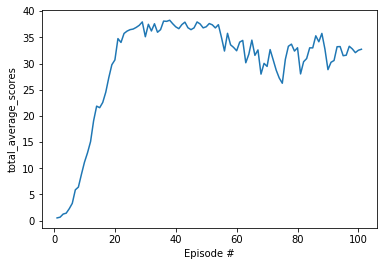

In [19]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(meanRs)+1), meanRs)
plt.ylabel('total_average_scores')
plt.xlabel('Episode #')
plt.show()

In [20]:
glosses = [-each[0] for each in losses__]

In [21]:
dlosses = [each[1] for each in losses__]

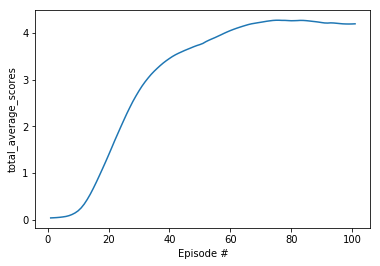

In [22]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(glosses)+1), glosses)
plt.ylabel('total_average_scores')
plt.xlabel('Episode #')
plt.show()

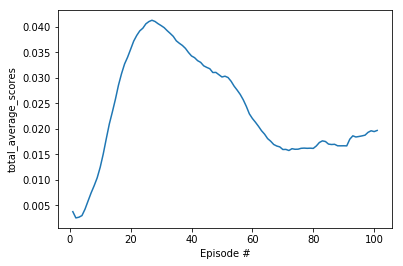

In [23]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(dlosses)+1), dlosses)
plt.ylabel('total_average_scores')
plt.xlabel('Episode #')
plt.show()

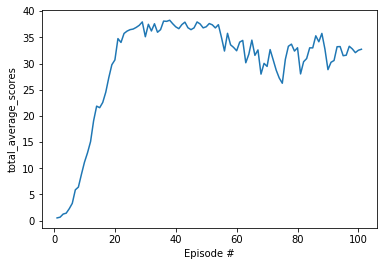

In [9]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(meanRs)+1), meanRs)
plt.ylabel('total_average_scores')
plt.xlabel('Episode #')
plt.show()

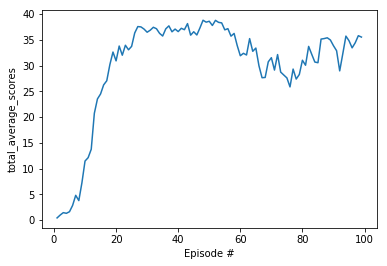

In [9]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(meanRs)+1), meanRs)
plt.ylabel('total_average_scores')
plt.xlabel('Episode #')
plt.show()

In [10]:
glosses = [-each[0] for each in losses__]

In [11]:
dlosses = [each[1] for each in losses__]

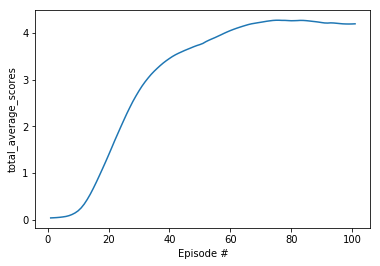

In [12]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(glosses)+1), glosses)
plt.ylabel('total_average_scores')
plt.xlabel('Episode #')
plt.show()

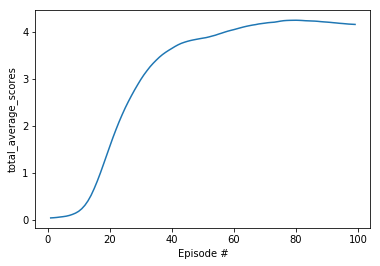

In [12]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(glosses)+1), glosses)
plt.ylabel('total_average_scores')
plt.xlabel('Episode #')
plt.show()

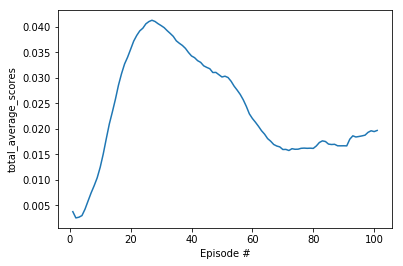

In [13]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(dlosses)+1), dlosses)
plt.ylabel('total_average_scores')
plt.xlabel('Episode #')
plt.show()

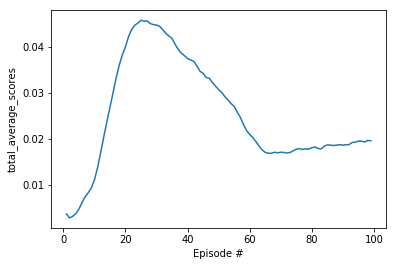

In [13]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(dlosses)+1), dlosses)
plt.ylabel('total_average_scores')
plt.xlabel('Episode #')
plt.show()

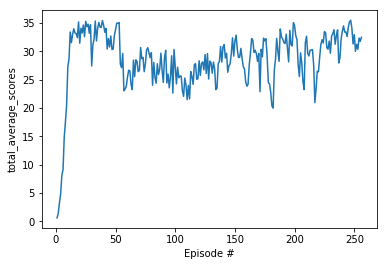

In [9]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(meanRs)+1), meanRs)
plt.ylabel('total_average_scores')
plt.xlabel('Episode #')
plt.show()

In [28]:
# len(losses__), [each[0] for each in losses__], losses__[0][0]

In [36]:
glosses = [-each[0] for each in losses__]

In [37]:
dlosses = [each[1] for each in losses__]

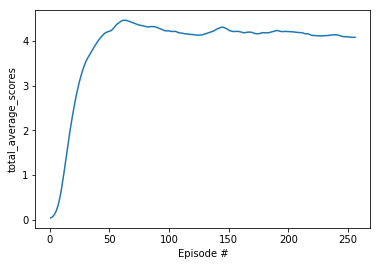

In [38]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(glosses)+1), glosses)
plt.ylabel('total_average_scores')
plt.xlabel('Episode #')
plt.show()

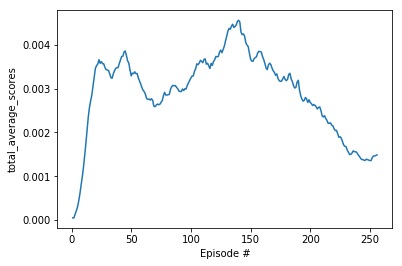

In [39]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(dlosses)+1), dlosses)
plt.ylabel('total_average_scores')
plt.xlabel('Episode #')
plt.show()

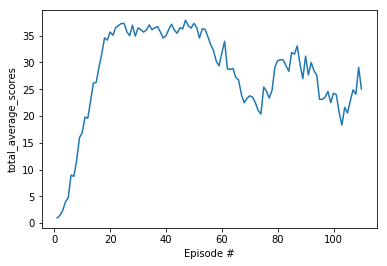

In [12]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(meanRs)+1), meanRs)
plt.ylabel('total_average_scores')
plt.xlabel('Episode #')
plt.show()

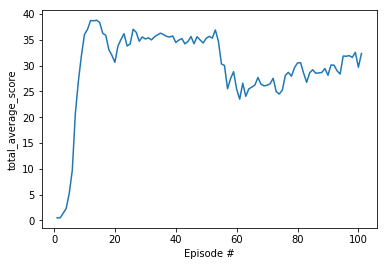

In [10]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(total_scores)+1), total_scores)
plt.ylabel('total_average_score')
plt.xlabel('Episode #')
plt.show()

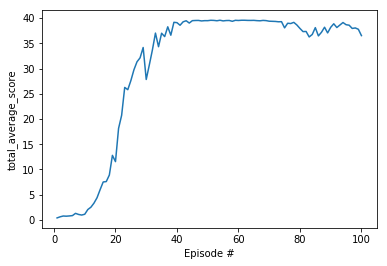

In [9]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(total_scores)+1), total_scores)
plt.ylabel('total_average_score')
plt.xlabel('Episode #')
plt.show()

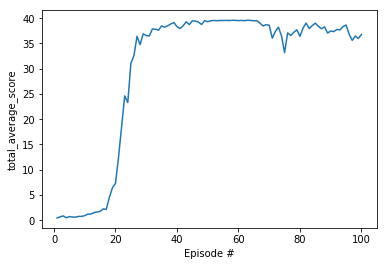

In [9]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(total_scores)+1), total_scores)
plt.ylabel('total_average_score')
plt.xlabel('Episode #')
plt.show()

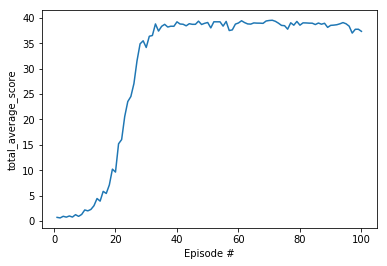

In [10]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(total_scores)+1), total_scores)
plt.ylabel('total_average_score')
plt.xlabel('Episode #')
plt.show()

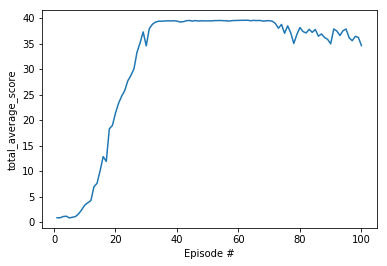

In [8]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(total_scores)+1), total_scores)
plt.ylabel('total_average_score')
plt.xlabel('Episode #')
plt.show()

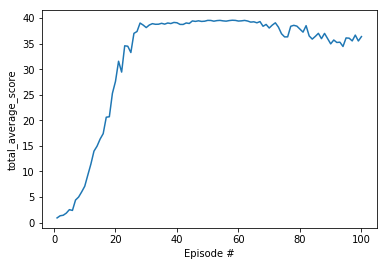

In [10]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(total_scores)+1), total_scores)
plt.ylabel('total_average_score')
plt.xlabel('Episode #')
plt.show()

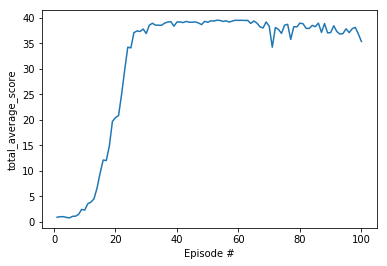

In [11]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(total_scores)+1), total_scores)
plt.ylabel('total_average_score')
plt.xlabel('Episode #')
plt.show()

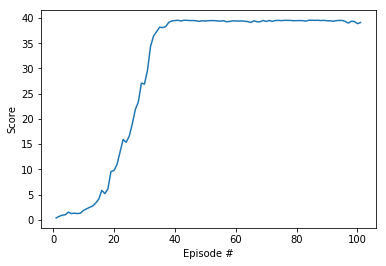

In [7]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

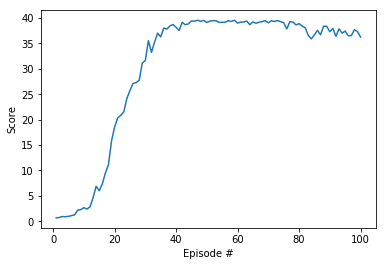

In [6]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

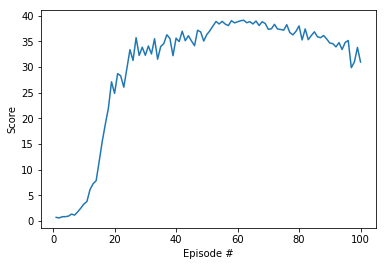

In [6]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

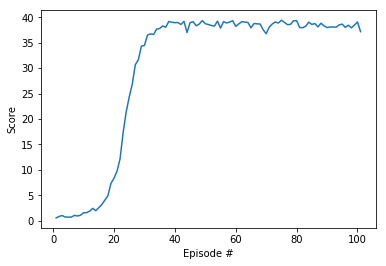

In [7]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

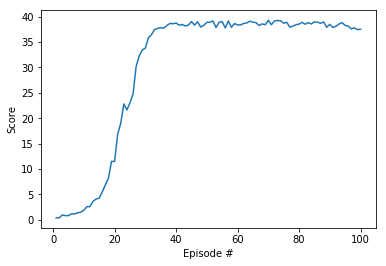

In [6]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

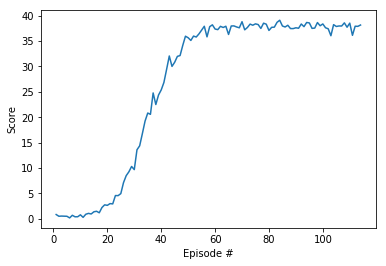

In [6]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

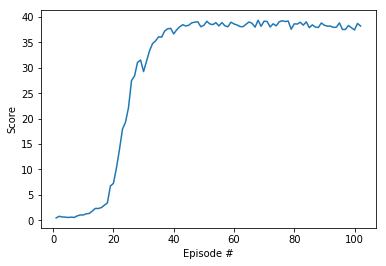

In [7]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 6. Watch the agent running with saved weights

In [14]:
# Load the saved weights into Pytorch model
agent.g.load_state_dict(torch.load('g-reacher-multiple.pth', map_location='cpu'))
agent.d.load_state_dict(torch.load('d-reacher-multiple.pth', map_location='cpu'))

env_info = env.reset(train_mode=False)[brain_name]     # reset the environment (env)
S = env_info.vector_observations                  # get the current states (S) (for all agents)

Rs = np.zeros(num_agents)                          # initialize the total scores (Rs) (for all agents)

while True:
    A = agent.act(S)                        # select actions (A) from loaded model agents
    
    env_info = env.step(A)[brain_name]           # send all actions (A) to the environment (env)
    S2 = env_info.vector_observations         # get next states (S2) (for all agents)
    rewards = env_info.rewards                         # get rewards (for all agents)
    dones = env_info.local_done                        # see if the episode is done/finished (terminal) for all agents
    
    Rs += rewards                         # update the total scores (Rs) (for all agents)
    S = S2                               # roll over current states (S) to next states (S2)
    
    if np.any(dones):                                  # exit loop if episode is done/finished for any of the agents among all of them
        break
        
print('Average of total scores: {}'.format(np.mean(Rs)))

Average of total scores: 36.017999194934966


When finished, you can close the environment.

In [10]:
env.close()